In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import plotly.graph_objects as go

1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

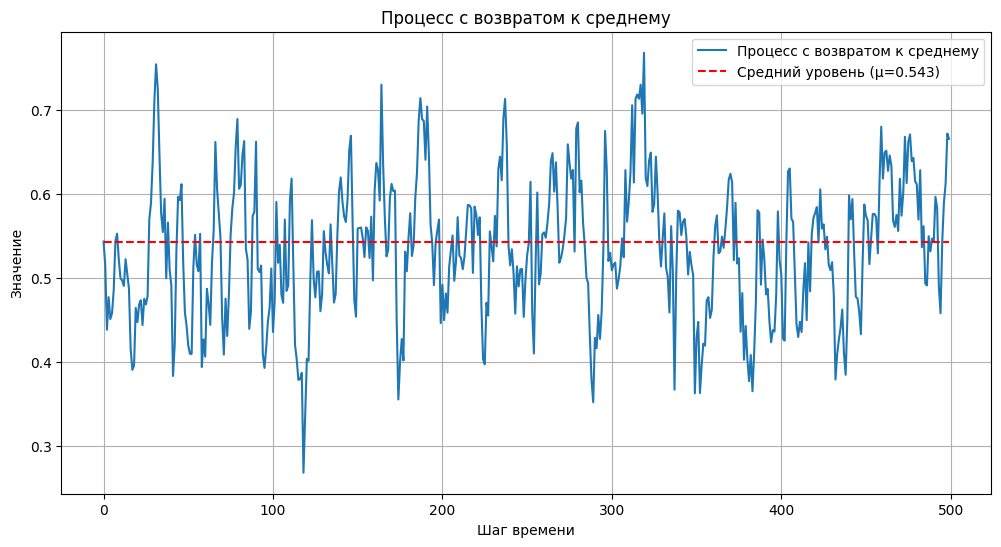

In [ ]:
# Параметры
a = 0.0        # Нижняя граница
b = 1.0        # Верхняя граница
num_steps = 500
k = 0.2        # Скорость возврата к среднему
sigma = 0.05   # Волатильность
seed = 100      # Для воспроизводимости

np.random.seed(seed)

mu = np.random.uniform(a, b)

X = np.zeros(num_steps)
X[0] = mu

# Генерация пути процесса
for t in range(1, num_steps):
    # Шаг с учетом возврата к среднему и гауссовского шума
    X_new = X[t-1] + k * (mu - X[t-1]) + sigma * np.random.randn()
    
    # Отражающие границы
    if X_new < a:
        X_new = a + (a - X_new)  # Отражаем обратно в интервал
    elif X_new > b:
        X_new = b - (X_new - b)  # Отражаем обратно в интервал
    
    # Обеспечиваем, чтобы X_new оставался в пределах [a, b]
    X[t] = np.clip(X_new, a, b)

# Временная ось
time = np.arange(num_steps)

plt.figure(figsize=(12, 6))
plt.plot(time, X, label='Процесс с возвратом к среднему')
plt.hlines(mu, xmin=0, xmax=num_steps-1, colors='red', linestyles='dashed', label=f'Средний уровень (μ={mu:.3f})')
plt.title(f'Процесс с возвратом к среднему')
plt.xlabel('Шаг времени')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

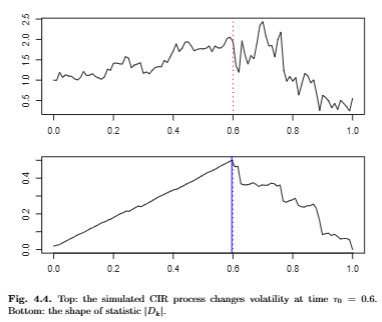

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

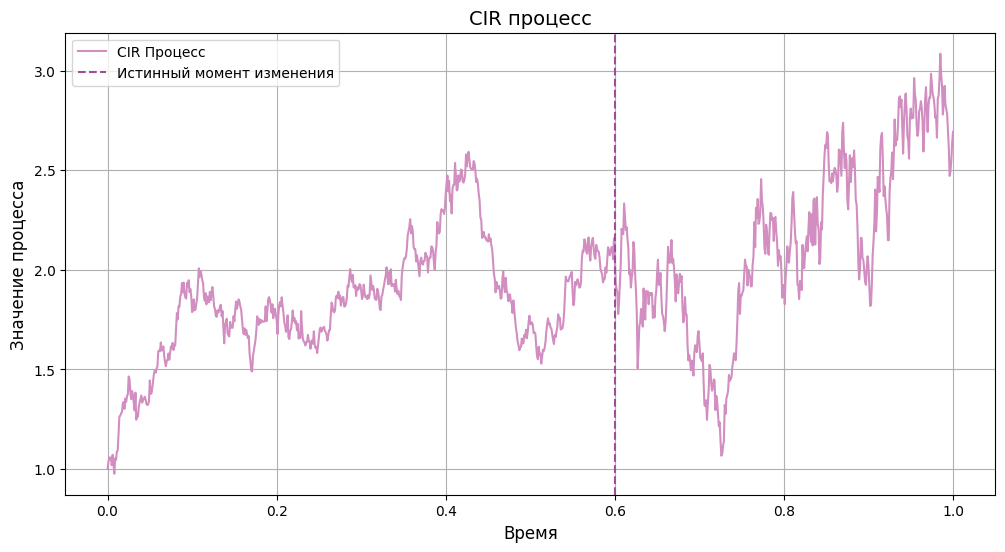

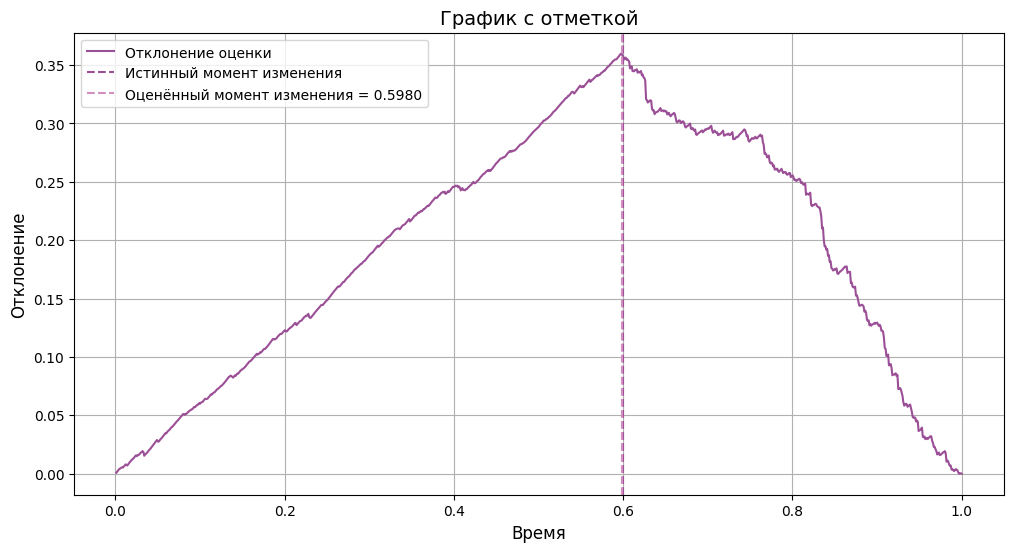

Истинный: t₀ = 0.6
Оценённый: y₀ = 0.5980


In [ ]:
class CIRProcessSimulation:
    def __init__(self, n=1000, T=1.0, tau0=0.6, theta1=1.0, theta2=2.0, X0=1.0):
        self.n = n
        self.T = T
        self.tau0 = tau0
        self.theta1 = theta1
        self.theta2 = theta2
        self.X0 = X0
        self.Δt = self.T / self.n
        self.t = np.linspace(0, self.T, self.n + 1)
        self.X = np.zeros(self.n + 1)
        self.X[0] = self.X0
        self.D_k = None

    def simulate(self):
        ΔW = np.sqrt(self.Δt) * np.random.randn(self.n)
        for i in range(self.n):
            theta = self.theta1 if self.t[i] < self.tau0 else self.theta2
            sqrt_Xi = np.sqrt(max(self.X[i], 0))
            self.X[i+1] = self.X[i] + (6 - 2 * self.X[i]) * self.Δt + theta * sqrt_Xi * ΔW[i]
            self.X[i+1] = max(self.X[i+1], 0)

    def estimate_change_point(self):
        Z = ((self.X[1:] - self.X[:-1]) - (6 - 2 * self.X[:-1]) * self.Δt) / np.sqrt(self.Δt)
        Z_squared = Z**2
        S_k = np.cumsum(Z_squared)
        S_n = S_k[-1]
        k_values = np.arange(1, self.n + 1)
        self.D_k = (S_k / S_n) - (k_values / self.n)
        k0 = np.argmax(np.abs(self.D_k))
        t0_estimate = self.t[k0 + 1]
        return t0_estimate

    def plot_process(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.t, self.X, color='#D28EC0', label='CIR Процесс')
        plt.axvline(x=self.tau0, color='#9B4F96', linestyle='--', label='Истинный момент изменения')
        plt.xlabel('Время', fontsize=12)
        plt.ylabel('Значение процесса', fontsize=12)
        plt.title('CIR процесс', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_estimation(self, t0_estimate):
        plt.figure(figsize=(12, 6))
        plt.plot(self.t[1:], np.abs(self.D_k), color='#9B4F96', label='Отклонение оценки')
        plt.axvline(x=self.tau0, color='#9B4F96', linestyle='--', label='Истинный момент изменения')
        plt.axvline(x=t0_estimate, color='#D28EC0', linestyle='--', label=f'Оценённый момент изменения = {t0_estimate:.4f}')
        plt.xlabel('Время', fontsize=12)
        plt.ylabel('Отклонение', fontsize=12)
        plt.title('График с oтметкой', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

def main():
    simulation = CIRProcessSimulation()
    simulation.simulate()
    t0_estimate = simulation.estimate_change_point()
    
    
    simulation.plot_process()
    
    
    simulation.plot_estimation(t0_estimate)
    
    print(f"Истинный: t₀ = {simulation.tau0}")
    print(f"Оценённый: y₀ = {t0_estimate:.4f}")

if __name__ == "__main__":
    main()

3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

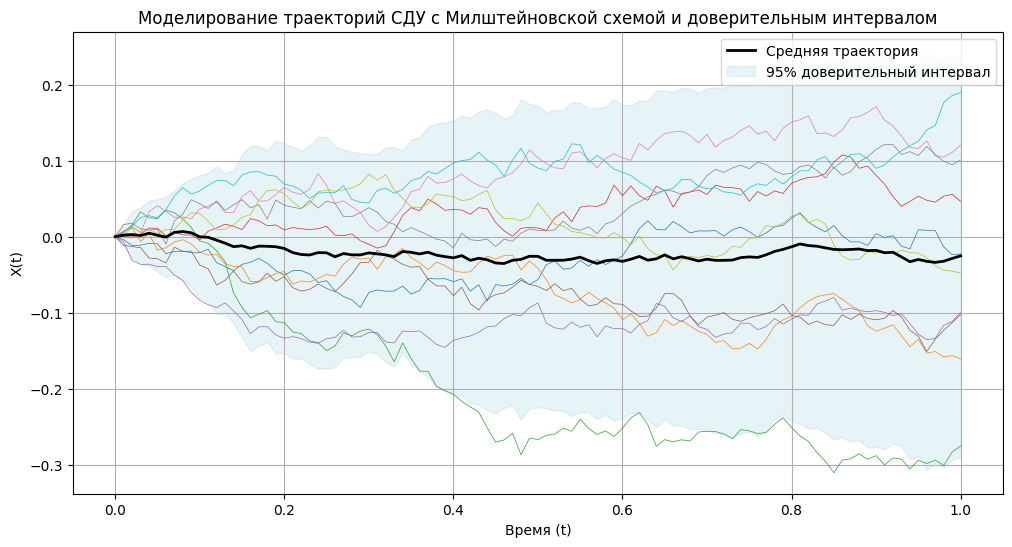

In [ ]:
T_end = 1
step_size = 0.01
total_steps = int(T_end / step_size)
initial_value = 0

def generate_milstein_trajectories(num_trajectories, T_end, step_size, total_steps, initial_value):
    time_points = np.linspace(0, T_end, total_steps + 1)
    paths = np.zeros((num_trajectories, total_steps + 1))
    paths[:, 0] = initial_value

    for trajectory in range(num_trajectories):
        for step in range(total_steps):
            current_time = step * step_size
            random_noise = np.sqrt(step_size) * np.random.randn()  # Генерация случайного шума для каждого шага
            current_value = paths[trajectory, step]
            drift_term = 0.03 * current_time * current_value - current_value**3
            diffusion_term = 0.1
            # Обновление по Милштейновской схеме
            paths[trajectory, step + 1] = current_value + drift_term * step_size + diffusion_term * random_noise + 0.5 * diffusion_term**2 * (random_noise**2 - step_size)

    return time_points, paths

# Количество траекторий для моделирования
trajectory_count = 10


time_points, paths = generate_milstein_trajectories(trajectory_count, T_end, step_size, total_steps, initial_value)
mean_path = np.mean(paths, axis=0)

# Стандартное отклонение для построения доверительного интервала (95%)
std_deviation = np.std(paths, axis=0)

plt.figure(figsize=(12, 6))

# Отображение всех траекторий
for trajectory in range(trajectory_count):
    plt.plot(time_points, paths[trajectory], linewidth=0.5, alpha=1)  # Прозрачность для отдельных траекторий

# Отображение средней траектории
plt.plot(time_points, mean_path, color='black', label="Средняя траектория", linewidth=2)

# Доверительный интервал (95%)
plt.fill_between(time_points, mean_path - 1.96 * std_deviation, mean_path + 1.96 * std_deviation, color='lightblue', alpha=0.3, label="95% доверительный интервал")

# Настройки графика
plt.title("Моделирование траекторий СДУ с Милштейновской схемой и доверительным интервалом")
plt.xlabel("Время (t)")
plt.ylabel("X(t)")
plt.legend(loc="best")
plt.grid(True)

# Показ графика
plt.show()

4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


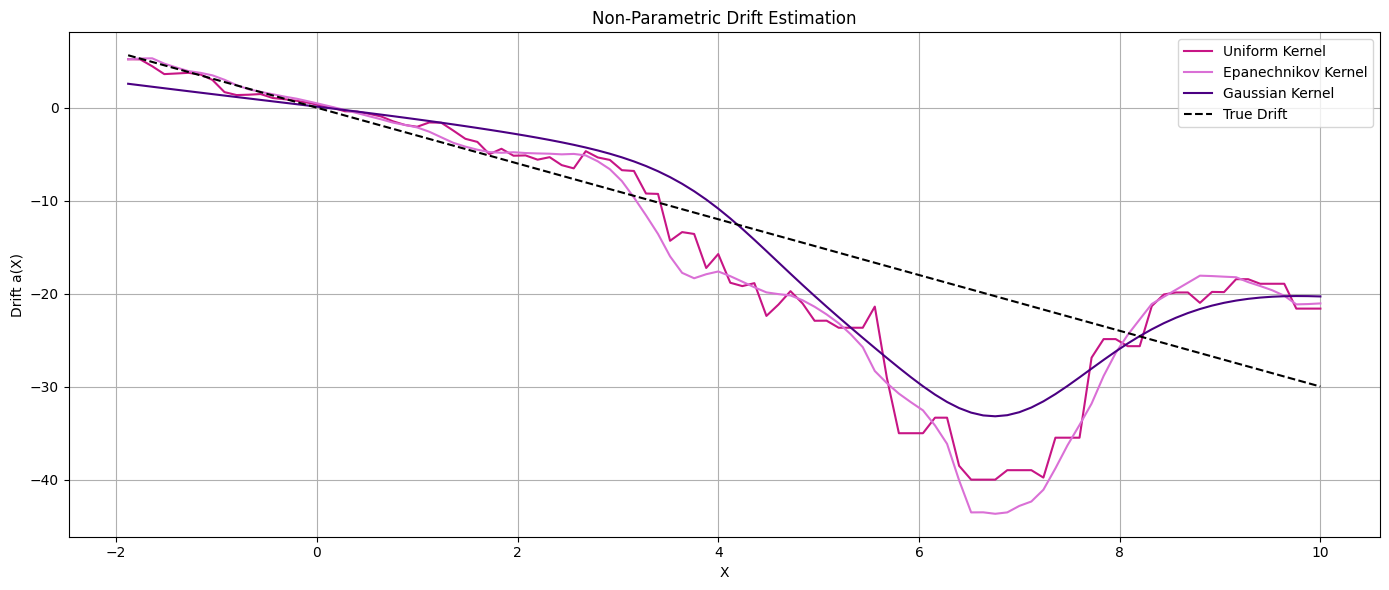

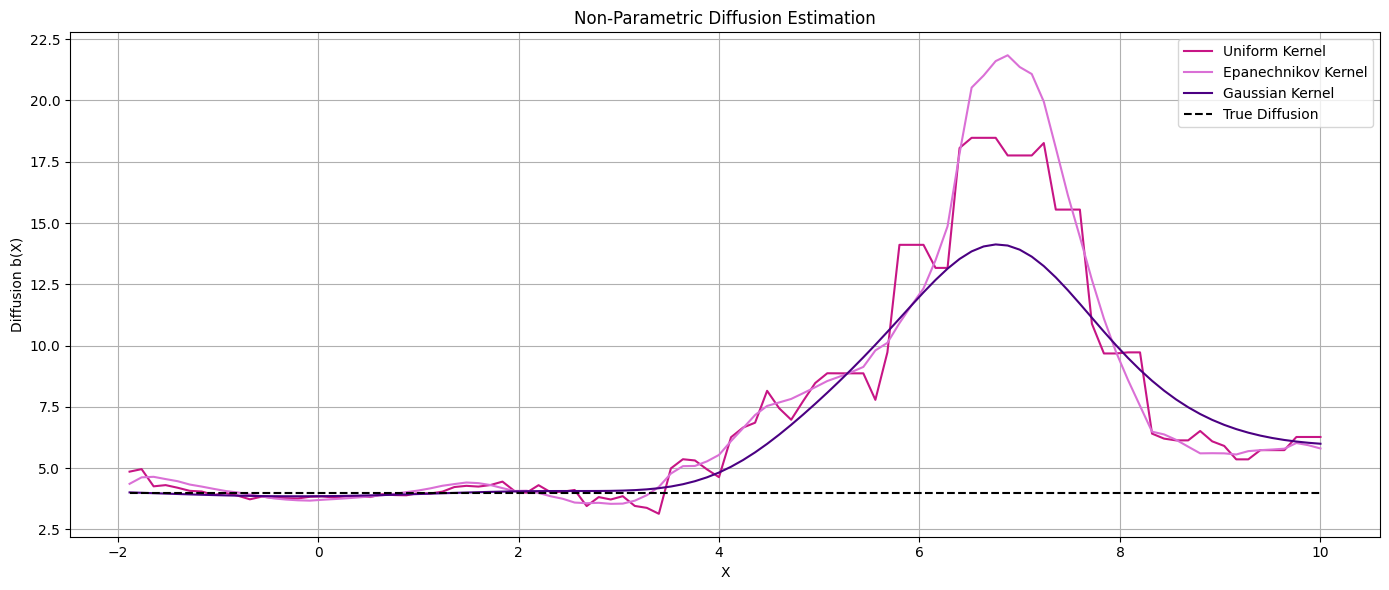

In [ ]:
class OrnsteinUhlenbeckSimulation:
    def __init__(self, theta1, theta2, theta3, X0, T=10, dt=0.01, seed=42):
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3
        self.X0 = X0
        self.T = T
        self.dt = dt
        self.N = int(T / dt)
        self.time = np.linspace(0, T, self.N+1)
        np.random.seed(seed)

    def simulate(self):
        X = np.zeros(self.N+1)
        X[0] = self.X0
        for i in range(1, self.N+1):
            dW = np.sqrt(self.dt) * np.random.randn()
            X[i] = X[i-1] + (self.theta1 - self.theta2 * X[i-1]) * self.dt + self.theta3 * dW
        return X

class KernelDensityEstimator:
    def __init__(self, kernel_func, h=1.0):
        self.kernel_func = kernel_func
        self.h = h

    def kernel_estimation(self, x_grid, X_prev, delta_X, dt):
        a_est = np.zeros_like(x_grid)
        b_est = np.zeros_like(x_grid)
        for idx, x in enumerate(x_grid):
            u = (X_prev - x) / self.h
            weights = self.kernel_func(u)
            sum_weights = np.sum(weights)
            if sum_weights > 0:
                a_est[idx] = np.sum(weights * (delta_X / dt)) / sum_weights
                b_est[idx] = np.sum(weights * ((delta_X)**2 / dt)) / sum_weights
            else:
                a_est[idx] = np.nan
                b_est[idx] = np.nan
        return a_est, b_est

def uniform_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return (0.75 * (1 - u**2)) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return norm.pdf(u)

def plot_results(X, time, X_prev, delta_X, x_grid, kernels, a_true, b_true):
    colors = ['mediumvioletred', 'orchid', 'indigo']

  
    plt.figure(figsize=(14, 6))
    for idx, (name, kernel) in enumerate(kernels.items()):
        estimator = KernelDensityEstimator(kernel)
        a_est, _ = estimator.kernel_estimation(x_grid, X_prev, delta_X, dt=0.01)

        plt.plot(x_grid, a_est, label=f'{name} Kernel', color=colors[idx])

    plt.plot(x_grid, a_true, 'k--', label='True Drift')
    plt.xlabel('X')
    plt.ylabel('Drift a(X)')
    plt.title('Non-Parametric Drift Estimation')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(14, 6))
    for idx, (name, kernel) in enumerate(kernels.items()):
        estimator = KernelDensityEstimator(kernel)
        _, b_est = estimator.kernel_estimation(x_grid, X_prev, delta_X, dt=0.01)

        plt.plot(x_grid, b_est, label=f'{name} Kernel', color=colors[idx])

    plt.plot(x_grid, b_true, 'k--', label='True Diffusion')
    plt.xlabel('X')
    plt.ylabel('Diffusion b(X)')
    plt.title('Non-Parametric Diffusion Estimation')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
   
    theta1 = 0
    theta2 = 3
    theta3 = 2
    X0 = 10
    
    # Simulate OU process
    ou_simulation = OrnsteinUhlenbeckSimulation(theta1, theta2, theta3, X0)
    X = ou_simulation.simulate()

    # Kernel estimation setup
    X_prev = X[:-1]
    delta_X = X[1:] - X[:-1]
    x_grid = np.linspace(np.min(X), np.max(X), 100)

    kernels = {
        'Uniform': uniform_kernel,
        'Epanechnikov': epanechnikov_kernel,
        'Gaussian': gaussian_kernel
    }

    a_true = -theta2 * x_grid
    b_true = theta3**2 * np.ones_like(x_grid)

    # Plot results
    plot_results(X, ou_simulation.time, X_prev, delta_X, x_grid, kernels, a_true, b_true)

if __name__ == '__main__':
    main()

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

In [5]:
import pandas as pd

df = pd.read_csv('exam.csv')

print(df.head())

# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(df['time'], df['value'], label='Data')
# plt.title('Stochastic Process Data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()

   Unnamed: 0         0
0    0.000000  0.500000
1    0.003333  0.462171
2    0.006667  0.433776
3    0.010000  0.460999
4    0.013333  0.473510


In [ ]:
class FinancialModels:
    def __init__(self, data_file):
        # Загрузка данных
        self.df = pd.read_csv(data_file)
        self.df.columns = ['Time', 'Value']
        self.time = self.df['Time'].values
        self.values = self.df['Value'].values
        self.dt = np.diff(self.time)
        self.theta_ou, self.mu_ou, self.sigma_ou = self.estimate_ou_params()
        self.mu_gbm, self.sigma_gbm = self.estimate_gbm_params()
        self.theta_cir, self.mu_cir, self.sigma_cir = self.estimate_cir_params()

    # Функция логарифмической правдоподобия для OU
    def ou_log_likelihood(self, params, x, dt):
        theta, mu, sigma = params
        n = len(x) - 1
        likelihood = 0
        for i in range(n):
            m = x[i] * np.exp(-theta * dt[i]) + mu * (1 - np.exp(-theta * dt[i]))
            s2 = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i]))
            likelihood += -0.5 * np.log(2 * np.pi * s2) - ((x[i+1] - m)**2) / (2 * s2)
        return -likelihood

    # Оценка параметров модели OU
    def estimate_ou_params(self):
        initial_guess = [1.0, np.mean(self.values), 0.1]
        result_ou = minimize(self.ou_log_likelihood, initial_guess, args=(self.values, self.dt),
                             bounds=((1e-5, None), (None, None), (1e-5, None)))
        return result_ou.x

    # Оценка параметров модели GBM
    def estimate_gbm_params(self):
        log_returns = np.diff(np.log(self.values))
        mu_gbm = np.mean(log_returns) / np.mean(self.dt)
        sigma_gbm = np.std(log_returns) / np.sqrt(np.mean(self.dt))
        return mu_gbm, sigma_gbm

    # Оценка параметров модели CIR методом моментов
    def moments_error(self, params, X_t, X_tp, dt):
        theta, mu, sigma = params
        if theta <= 0 or mu <= 0 or sigma <= 0:
            return np.inf
        mean_X_t = np.mean(X_t)
        mean_X_tp = np.mean(X_tp)
        var_X_tp = np.var(X_tp)
        E_X_tp = mean_X_t * np.exp(-theta * dt.mean()) + mu * (1 - np.exp(-theta * dt.mean()))
        Var_X_tp = (sigma**2 * mean_X_t) / (2 * theta) * (1 - np.exp(-2 * theta * dt.mean()))
        error1 = (E_X_tp - mean_X_tp)**2
        error2 = (Var_X_tp - var_X_tp)**2
        return error1 + error2

    def estimate_cir_params(self):
        X_t = self.values[:-1]
        X_tp = self.values[1:]
        initial_guess = [1.0, np.mean(self.values), 0.1]
        result = minimize(self.moments_error, initial_guess, args=(X_t, X_tp, self.dt),
                          bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
        if result.success:
            return result.x
        else:
            raise RuntimeError("Оптимизация не сошлась для метода моментов.")

    # Моделирование процесса Cox-Ingersoll-Ross
    def simulate_cir(self, theta, mu, sigma, x0, dt, n_steps):
        x = np.zeros(n_steps)
        x[0] = x0
        for i in range(1, n_steps):
            mean = x[i-1] * np.exp(-theta * dt[i-1]) + mu * (1 - np.exp(-theta * dt[i-1]))
            variance = (sigma**2 * x[i-1] / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i-1]))
            x[i] = mean + np.sqrt(variance) * np.random.normal()
            x[i] = max(x[i], 0)
        return x

    # Моделирование процесса Ornstein-Uhlenbeck
    def simulate_ou(self, theta, mu, sigma, x0, dt, n_steps):
        x = np.zeros(n_steps)
        x[0] = x0
        for i in range(1, n_steps):
            x[i] = x[i-1] + theta * (mu - x[i-1]) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal()
        return x

    # Моделирование процесса Geometric Brownian Motion
    def simulate_gbm(self, mu, sigma, x0, dt, n_steps):
        x = np.zeros(n_steps)
        x[0] = x0
        for i in range(1, n_steps):
            x[i] = x[i-1] * np.exp((mu - 0.5 * sigma**2) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal())
        return x

    # Расчет MSE для моделей
    def compute_mse(self, actual, simulated):
        return np.mean((actual - simulated)**2)

    
    def plot_comparison(self, cir_sim, ou_sim, gbm_sim):
        trace1 = go.Scatter(x=self.time, y=self.values, mode='lines', name='Исходные данные', line=dict(color='orange', width=2))
        trace2 = go.Scatter(x=self.time, y=ou_sim, mode='lines', name='Ornstein-Uhlenbeck', line=dict(color='purple', dash='dash'))
        trace3 = go.Scatter(x=self.time, y=gbm_sim, mode='lines', name='Geometric Brownian Motion', line=dict(color='pink', dash='dash'))
        trace4 = go.Scatter(x=self.time, y=cir_sim, mode='lines', name='Cox-Ingersoll-Ross', line=dict(color='red', dash='dash'))

        layout = go.Layout(
            title='Сравнение моделей',
            xaxis=dict(title='Время'),
            yaxis=dict(title='Значение'),
            showlegend=True
        )

        fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
        fig.show()

    # Основной код для моделирования и визуализации
    def run(self):
        np.random.seed(42)
        cir_sim = self.simulate_cir(self.theta_cir, self.mu_cir, self.sigma_cir, self.values[0], self.dt, len(self.values))
        ou_sim = self.simulate_ou(self.theta_ou, self.mu_ou, self.sigma_ou, self.values[0], self.dt, len(self.values))
        gbm_sim = self.simulate_gbm(self.mu_gbm, self.sigma_gbm, self.values[0], self.dt, len(self.values))

        mse_ou = self.compute_mse(self.values, ou_sim)
        mse_gbm = self.compute_mse(self.values, gbm_sim)
        mse_cir = self.compute_mse(self.values, cir_sim)

        print(f"MSE Ornstein-Uhlenbeck: {mse_ou}")
        print(f"MSE Geometric Brownian Motion: {mse_gbm}")
        print(f"MSE Cox-Ingersoll-Ross: {mse_cir}")

        # Рисуем графики
        self.plot_comparison(cir_sim, ou_sim, gbm_sim)

# Использование класса
model = FinancialModels('exam.csv')
model.run()

MSE Ornstein-Uhlenbeck: 0.06611637751993628
MSE Geometric Brownian Motion: 0.10135153728601841
MSE Cox-Ingersoll-Ross: 0.025956909811014686
